In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"device: {device}")
torch.set_default_device(device)

device: mps


In [3]:
class Generator(nn.Module):
    def __init__(self, noise_dim=100, img_dim=784):  # 28*28=784 cho MNIST
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, img_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.gen(x)

class Discriminator(nn.Module):
    def __init__(self, img_dim=784):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Linear(img_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.disc(x)

In [4]:
# random noise vector
noise_dim = 100

# init Generator and Discriminator
gen = Generator(noise_dim).to(device=device)
disc = Discriminator().to(device=device)

# loss and optimizers
criterion = nn.BCELoss().to(device=device)
optimizer_gen = optim.Adam(gen.parameters(), lr=0.0002)
optimizer_disc = optim.Adam(disc.parameters(), lr=0.0002)

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalization để đưa ảnh về khoảng [-1, 1]
])

dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, generator=torch.Generator(device=device))

In [6]:
num_epochs = 50
for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(dataloader):
        batch_size = real.size(0)
        real: torch.Tensor = real.view(batch_size, -1).to(device=device)

        # Labels for real and fake
        labels_real = torch.ones(batch_size, 1).to(device=device)
        labels_fake = torch.zeros(batch_size, 1).to(device=device)

        # train Discriminator for real
        disc_real = disc(real)
        loss_disc_real = criterion(disc_real, labels_real)

        # train Discriminator for fake
        noise = torch.randn(batch_size, noise_dim)
        fake_images = gen(noise)
        disc_fake = disc(fake_images.detach())
        loss_disc_fake = criterion(disc_fake, labels_fake)

        # total loss of Discriminator
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        optimizer_disc.zero_grad()
        loss_disc.backward()
        optimizer_disc.step()

        # train Generator to fool Discriminator
        output = disc(fake_images)
        loss_gen = criterion(output, labels_real)
        optimizer_gen.zero_grad()
        loss_gen.backward()
        optimizer_gen.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss D: {loss_disc:.4f}, Loss G: {loss_gen:.4f}")

Epoch [1/50] | Loss D: 0.3031, Loss G: 1.6863
Epoch [2/50] | Loss D: 0.1794, Loss G: 1.5775
Epoch [3/50] | Loss D: 0.1119, Loss G: 3.8468
Epoch [4/50] | Loss D: 0.1673, Loss G: 3.2769
Epoch [5/50] | Loss D: 0.4402, Loss G: 2.0945
Epoch [6/50] | Loss D: 0.5520, Loss G: 2.6965
Epoch [7/50] | Loss D: 0.3263, Loss G: 2.0846
Epoch [8/50] | Loss D: 0.4780, Loss G: 1.6321
Epoch [9/50] | Loss D: 0.4200, Loss G: 1.6904
Epoch [10/50] | Loss D: 0.4795, Loss G: 1.9828
Epoch [11/50] | Loss D: 0.3975, Loss G: 1.9652
Epoch [12/50] | Loss D: 0.4122, Loss G: 1.3313
Epoch [13/50] | Loss D: 0.5720, Loss G: 1.3472
Epoch [14/50] | Loss D: 0.5525, Loss G: 1.3218
Epoch [15/50] | Loss D: 0.6974, Loss G: 1.2999
Epoch [16/50] | Loss D: 0.4532, Loss G: 1.7933
Epoch [17/50] | Loss D: 0.5598, Loss G: 2.0975
Epoch [18/50] | Loss D: 0.5065, Loss G: 1.2869
Epoch [19/50] | Loss D: 0.5755, Loss G: 1.7295
Epoch [20/50] | Loss D: 0.5054, Loss G: 1.3014
Epoch [21/50] | Loss D: 0.6409, Loss G: 1.4698
Epoch [22/50] | Loss D

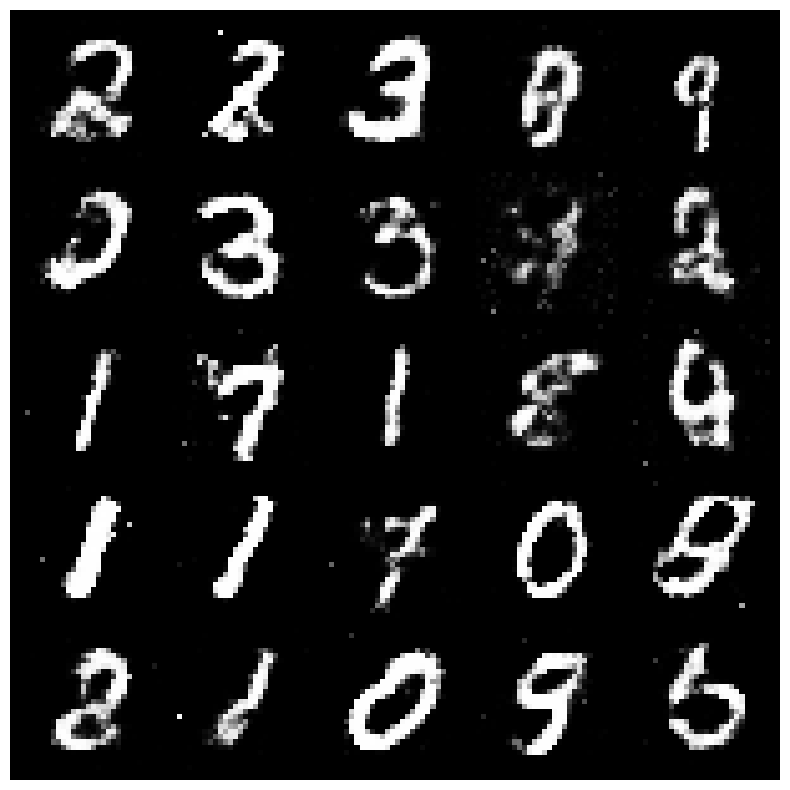

In [7]:
def generate_and_plot_images(generator, noise_dim, num_images=25):
    noise = torch.randn(num_images, noise_dim)
    fake_images = generator(noise).view(-1, 1, 28, 28)
    fake_images = (fake_images + 1) / 2  # scale to khoảng [0, 1]

    grid = torchvision.utils.make_grid(fake_images, nrow=5)
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(grid.detach().cpu().numpy(), (1, 2, 0)))
    plt.axis("off")
    plt.show()

# generate
generate_and_plot_images(gen, noise_dim)